In [1]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
from pathlib import Path
sys.path.append('../src')
from load_derived_FLASH_fields import derive_fields

In [2]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d %H:%M:%S')

'2024-11-04 12:36:50'

In [3]:
# make plot text bigger

import matplotlib.pylab as pylab
import yt.config
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [4]:
# plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"
plot_path = "/home/dschneidinger/cellar/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0006"

ds = derive_fields(plot_path)

yt : [INFO     ] 2024-11-04 12:38:11,783 Particle file found: MagShockZ_hdf5_chk_0006
yt : [INFO     ] 2024-11-04 12:38:11,805 Parameters: current_time              = 4.157630190965378e-09
yt : [INFO     ] 2024-11-04 12:38:11,805 Parameters: domain_dimensions         = [384 496 384]
yt : [INFO     ] 2024-11-04 12:38:11,805 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2024-11-04 12:38:11,805 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2024-11-04 12:38:11,805 Parameters: cosmological_simulation   = 0


In [5]:
ds.domain_dimensions

array([384, 496, 384], dtype=int32)

In [6]:
mins = ds.domain_left_edge
maxs = ds.domain_right_edge
print(mins)
print(maxs)

[-0.8   -0.075 -0.8  ] code_length
[0.8 2.  0.8] code_length


In [7]:
# create covering grid from ds
level = 2
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
    # And any fields to preload (this is optional!)
)
# density and electron temp at y=0
z_middle_index = dims[2] // 2
# dens = pd.DataFrame(all_data['flash', 'dens'][:, :, z_middle_index])
# tele = pd.DataFrame(all_data['flash', 'tele'][:, :, z_middle_index])

In [12]:
plt.figure(figsize=(10,10))
im = plt.imshow(dens.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04) # fraction and pad are for sizing the colorbar
cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.minorticks_on()
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Mass density at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1561517/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
/tmp/ipykernel_1561517/2696657589.py:5: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')


NameError: name 'dens' is not defined

<Figure size 1000x1000 with 0 Axes>

In [13]:
plt.figure(figsize=(10,10))
im = plt.imshow(tele.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04)
cbar.set_label('temperature (K)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Electron temp at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

NameError: name 'tele' is not defined

<Figure size 1000x1000 with 0 Axes>

yt : [INFO     ] 2024-11-04 12:38:24,593 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-11-04 12:38:24,594 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-11-04 12:38:24,595 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-11-04 12:38:24,595 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-11-04 12:38:24,596 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800
yt : [INFO     ] 2024-11-04 12:38:24,943 Saving plot ../results/FLASH_plots/edens_slice.png



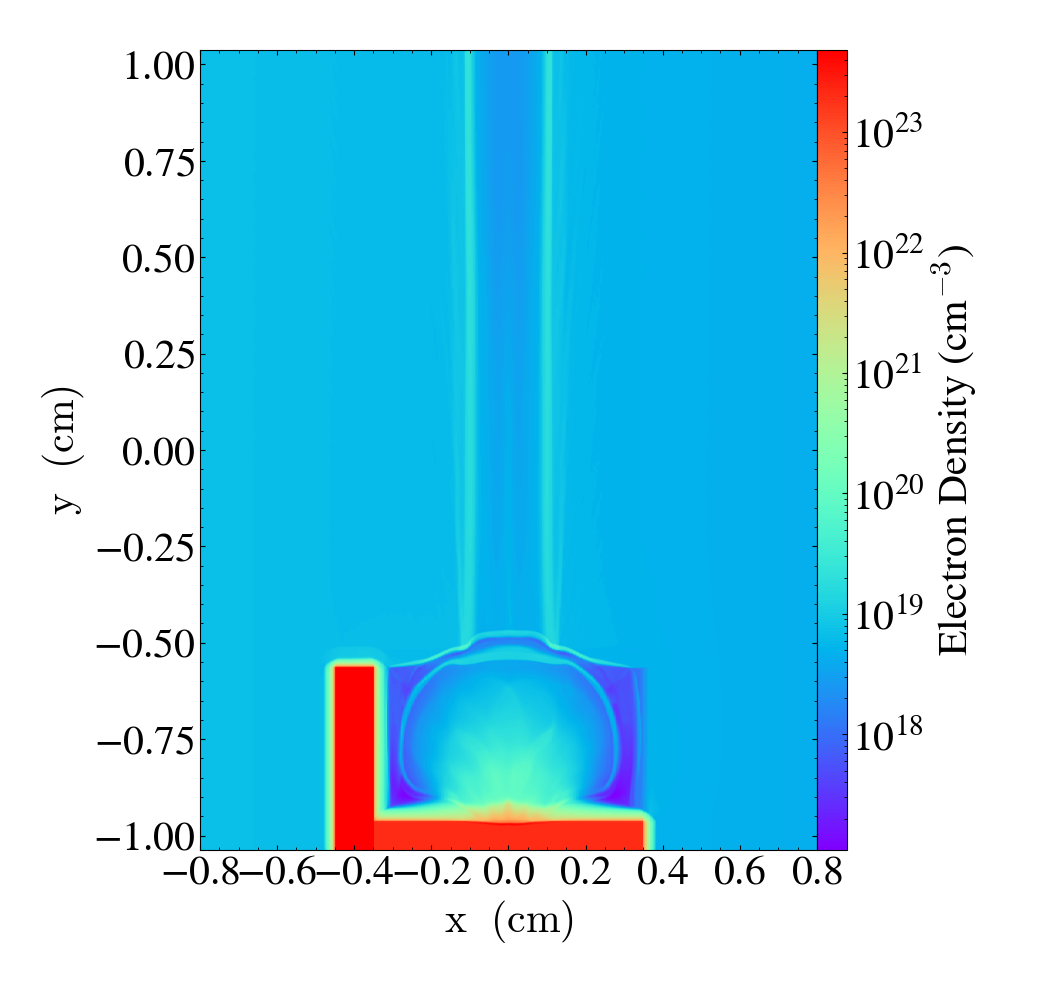

In [8]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens")).zoom(1).set_cmap("edens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("edens", r"Electron Density (cm$^{-3}$)")
slc.save("../results/FLASH_plots/edens_slice.png")
slc.show()

yt : [INFO     ] 2024-10-02 11:21:34,680 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:21:34,680 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:21:34,682 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:21:34,683 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:21:34,683 Making a fixed resolution buffer of (('flash', 'aldens')) 800 by 800


yt : [INFO     ] 2024-10-02 11:21:36,478 Saving plot ../results/FLASH_plots/aldens_slice.png



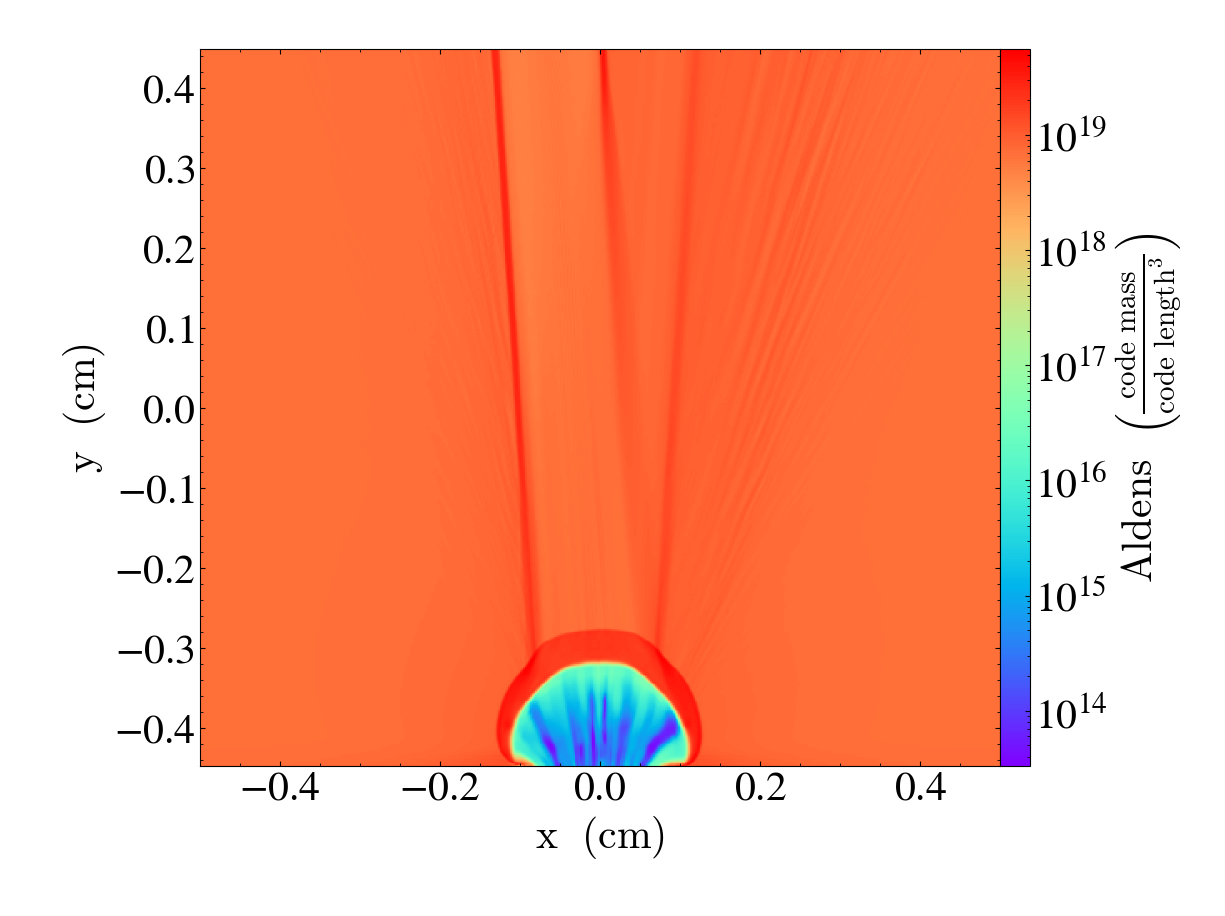

In [28]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","aldens")).zoom(1.2).set_cmap("aldens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("idens", r"Aluminum Density (g/cm$^3$)")
slc.save("../results/FLASH_plots/aldens_slice.png")
slc.show()

yt : [INFO     ] 2024-10-02 11:43:59,512 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:43:59,513 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:43:59,515 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:43:59,516 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:43:59,516 Making a fixed resolution buffer of (('flash', 'magp')) 800 by 800
yt : [INFO     ] 2024-10-02 11:43:59,979 Saving plot ../results/FLASH_plots/magp_slice.png



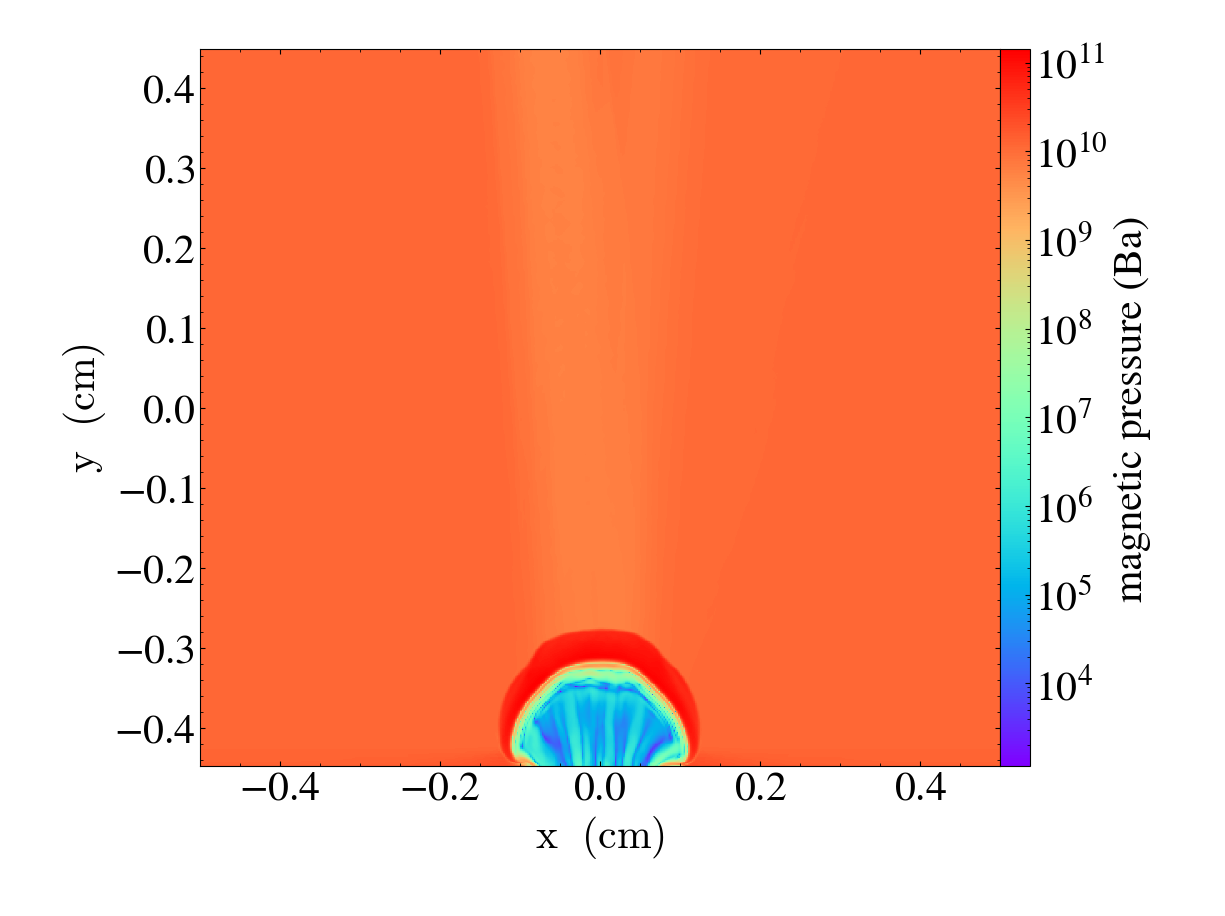

In [54]:
slc = yt.SlicePlot(ds, "z", ("flash","magp")).zoom(1.2).set_cmap("magp","rainbow")
# slc.set_log("magp", False)
slc.set_colorbar_label("magp", "magnetic pressure (Ba)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/magp_slice.png")
slc.show()

yt : [INFO     ] 2024-10-02 11:26:46,896 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:26:46,897 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:26:46,900 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:26:46,901 ylim = -0.075000 1.000000


yt : [INFO     ] 2024-10-02 11:26:46,902 Making a fixed resolution buffer of (('flash', 'tele')) 800 by 800
yt : [INFO     ] 2024-10-02 11:26:48,524 Saving plot ../results/FLASH_plots/tele_slice.png



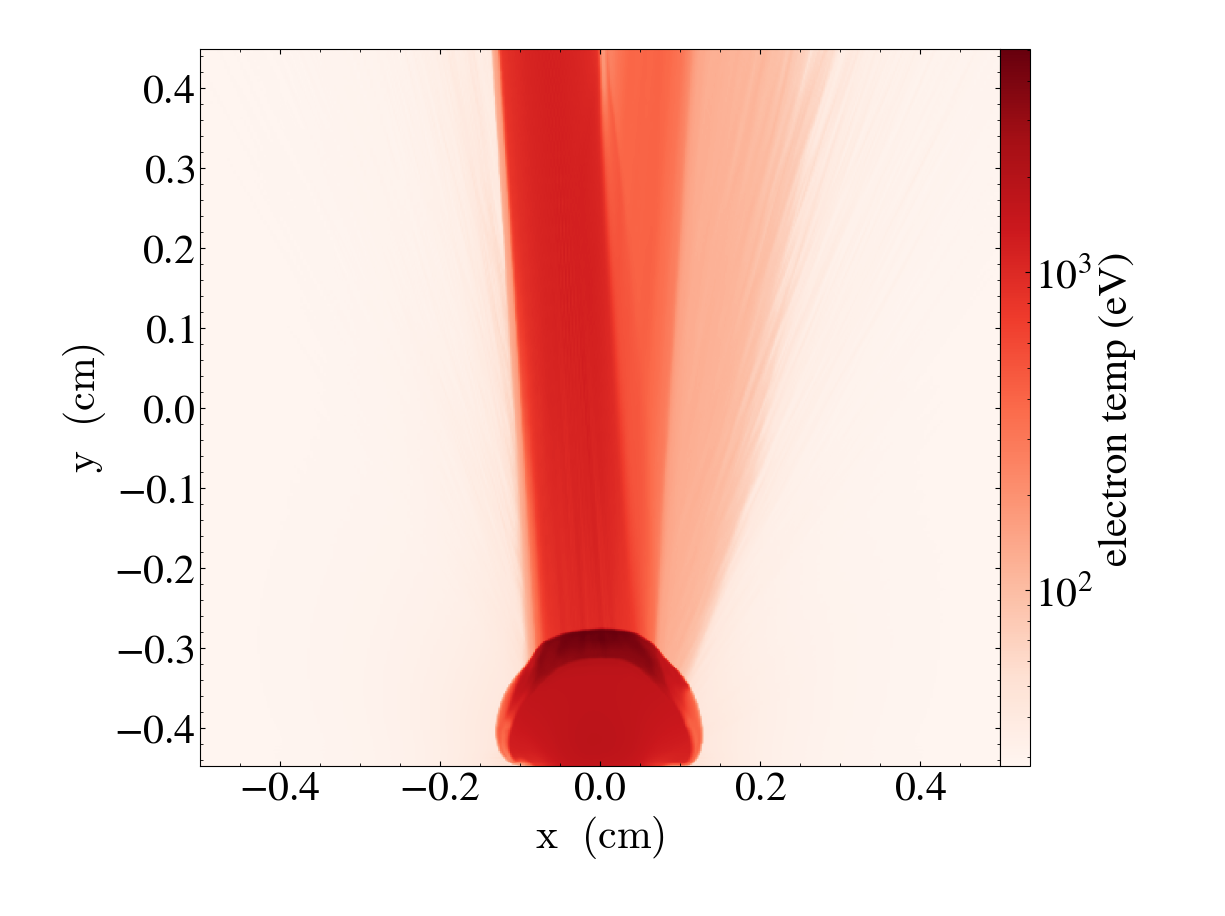

In [35]:
slc = yt.SlicePlot(ds, "z", ("flash","tele")).zoom(1.2).set_cmap("tele","Reds")
kb = 8.617333262e-5
# slc.set_log("tele", False)
slc.frb["flash","tele"] *= kb
slc.set_colorbar_label("tele", "electron temp (eV)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/tele_slice.png")
slc.show()

yt : [INFO     ] 2024-10-02 11:40:02,191 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:40:02,192 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:40:02,194 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:40:02,194 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:40:02,195 Making a fixed resolution buffer of (('flash', 'tion')) 800 by 800
yt : [INFO     ] 2024-10-02 11:40:02,634 Saving plot ../results/FLASH_plots/tion_slice.png



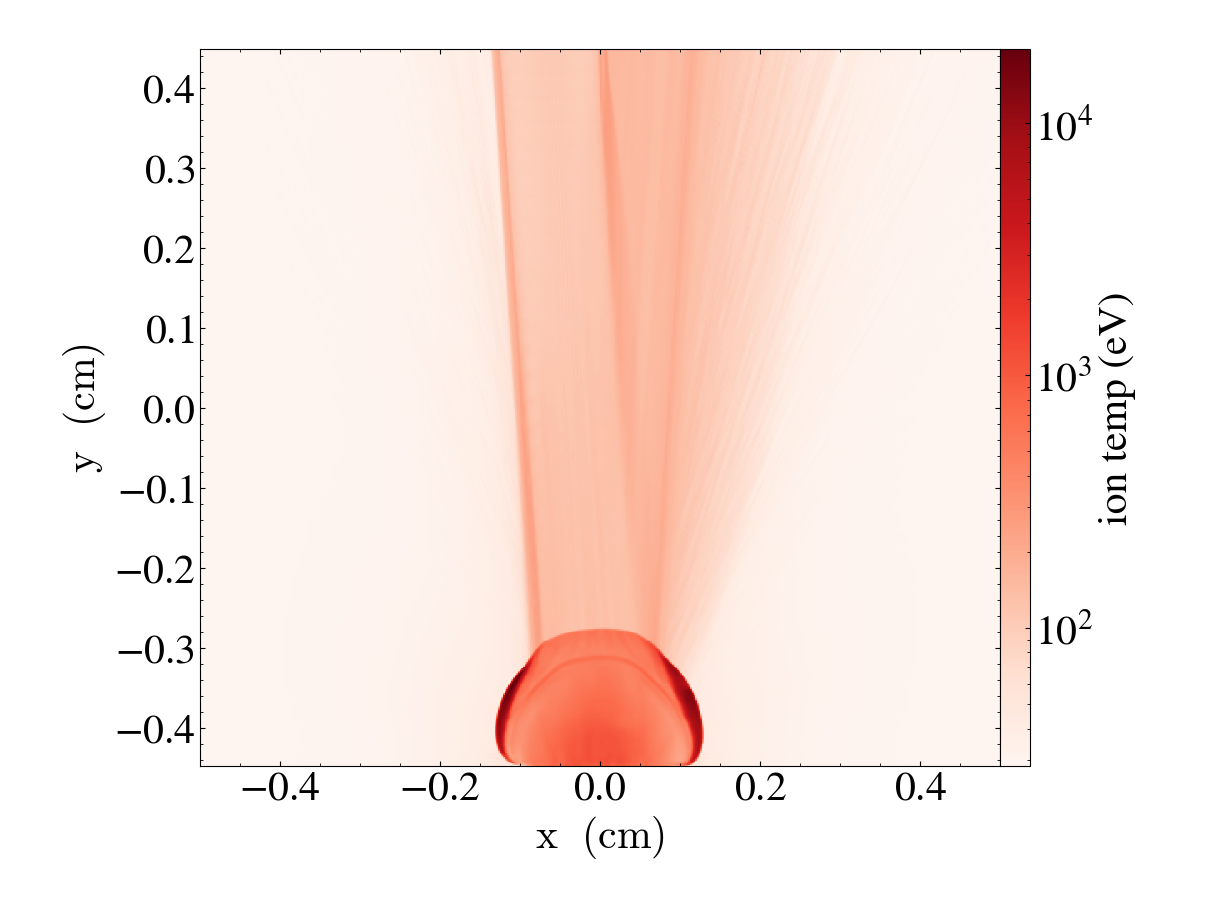

In [43]:
slc = yt.SlicePlot(ds, "z", ("flash","tion")).zoom(1.2).set_cmap("tion","Reds")
kb = 8.617333262e-5
slc.frb["flash","tion"] *= kb
slc.set_colorbar_label("tion", "ion temp (eV)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/tion_slice.png")
slc.show()

yt : [INFO     ] 2024-10-02 11:30:43,060 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:30:43,061 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:30:43,063 xlim = -0.600000 0.600000
yt : [INFO     ] 2024-10-02 11:30:43,063 ylim = -0.075000 1.000000
yt : [INFO     ] 2024-10-02 11:30:43,064 Making a fixed resolution buffer of (('flash', 'vely')) 800 by 800


6900127.060405759


yt : [INFO     ] 2024-10-02 11:30:44,520 Saving plot ../results/FLASH_plots/vely_slice.png



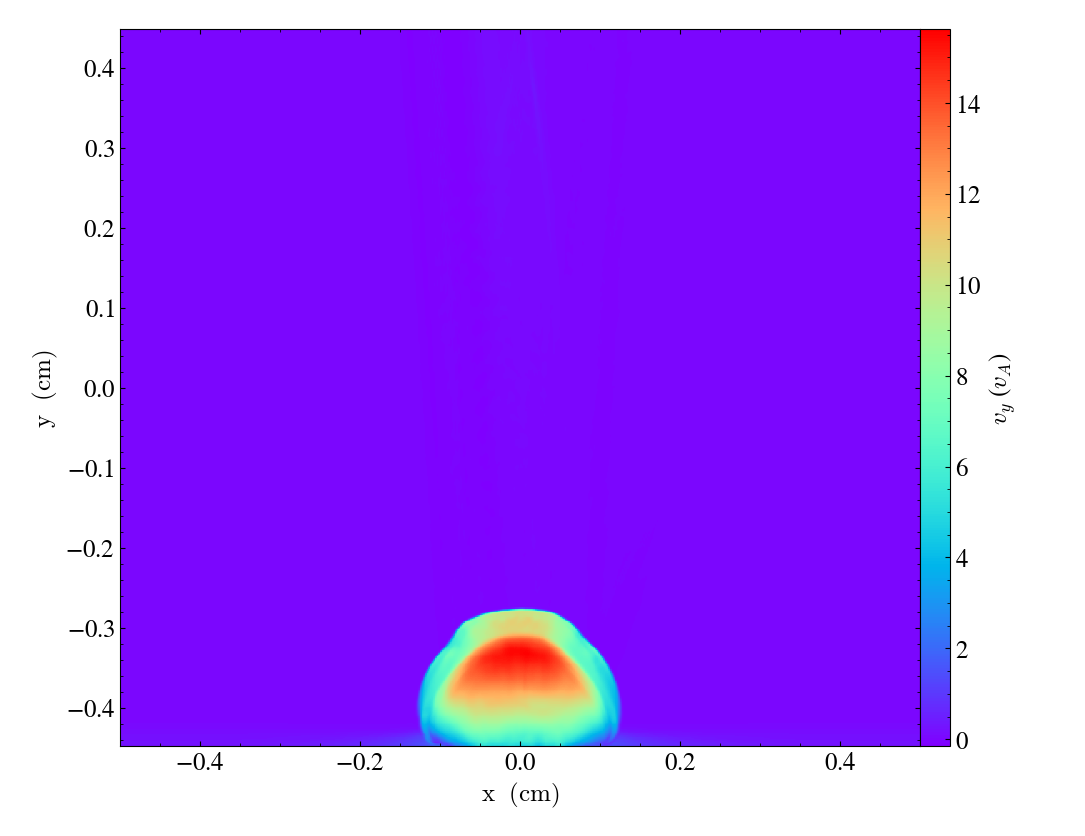

In [41]:
slc = yt.SlicePlot(ds, "z", ("flash","vely")).zoom(1.2).set_cmap("vely","rainbow")
slc.set_log("vely", False)
aluminum_molecular_weight = 26.98
proton_mass = 1.6726219e-24
ne_cgs = 5e18
Al_charge_state = 6
rho_0 = aluminum_molecular_weight*proton_mass*ne_cgs/Al_charge_state
v_alfven = 150000/np.sqrt(4*np.pi*rho_0)
print(v_alfven)
slc.frb["flash","vely"] = slc.frb["flash","vely"]/v_alfven
slc.set_colorbar_label("vely", "$v_y$ ($v_A$)")
slc.save("../results/FLASH_plots/vely_slice.png")
slc.show()

In [55]:
plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

sys.path.append("../src")
ds = derive_fields(plot_path)

yt : [INFO     ] 2024-10-02 11:50:05,495 Particle file found: MagShockZ_hdf5_chk_0005
yt : [INFO     ] 2024-10-02 11:50:05,605 Parameters: current_time              = 1.975372613538229e-09
yt : [INFO     ] 2024-10-02 11:50:05,606 Parameters: domain_dimensions         = [384 544 384]
yt : [INFO     ] 2024-10-02 11:50:05,606 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2024-10-02 11:50:05,607 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2024-10-02 11:50:05,607 Parameters: cosmological_simulation   = 0


yt : [INFO     ] 2024-10-02 11:56:52,974 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-10-02 11:56:52,975 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-10-02 11:56:52,977 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-10-02 11:56:52,977 ylim = -0.075000 2.000000
yt : [INFO     ] 2024-10-02 11:56:52,978 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800
yt : [INFO     ] 2024-10-02 11:56:53,580 Saving plot ../results/FLASH_plots/edens_slice_with_shield.png



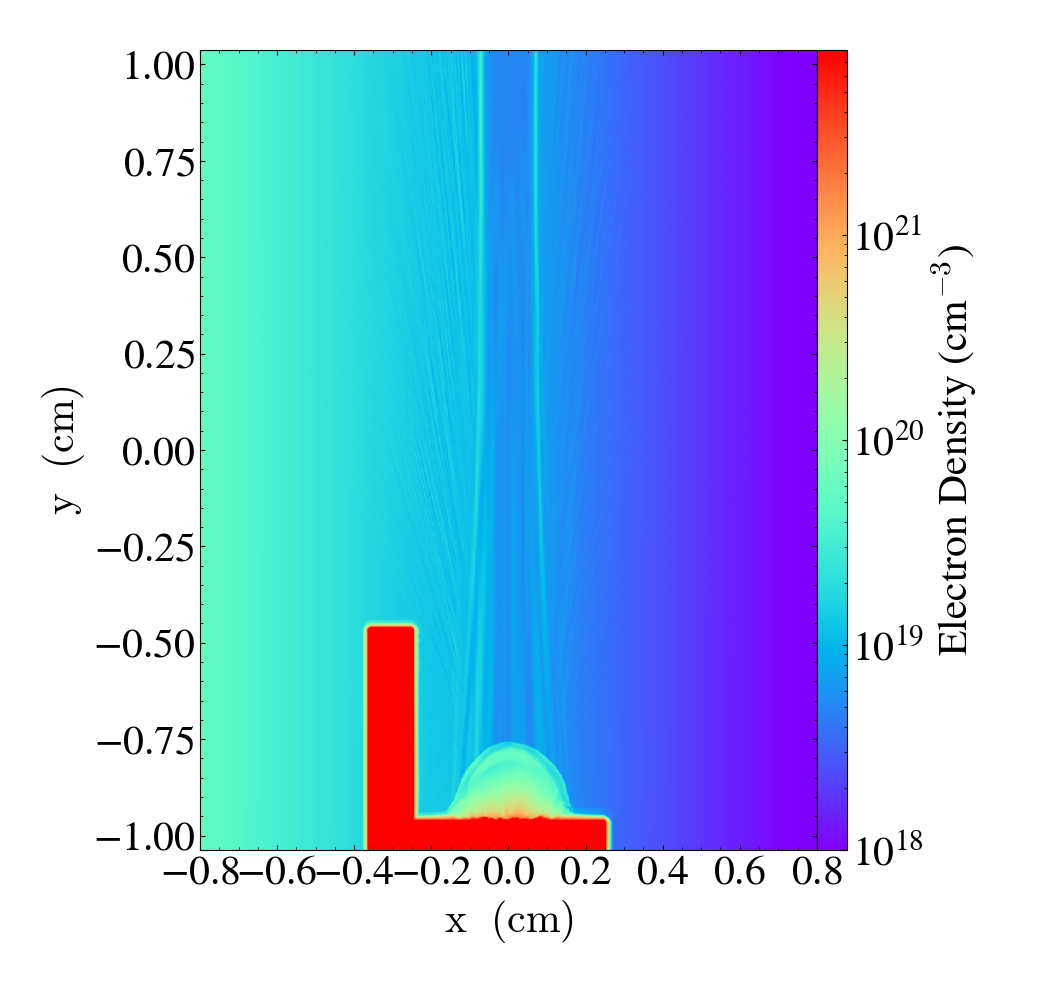

In [69]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens")).zoom(1).set_cmap("edens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("edens", r"Electron Density (cm$^{-3}$)")
slc.set_zlim("edens", 1e18, 8e21)
slc.save("../results/FLASH_plots/edens_slice_with_shield.png")
slc.show()